## Classification

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import check_array, check_X_y
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import cross_val_score, train_test_split

In [2]:
df = pd.read_csv("height-weight.csv")
df

,Height,Weight,Gender
0,65.343203,155.729380,Male
1,63.884876,126.938871,Female
2,66.837536,160.397323,Female
3,67.155649,176.219279,Male
4,65.725572,130.568403,Female
...,...,...,...
9995,65.487640,146.060156,Female
9996,61.494342,121.272605,Female
9997,65.428510,128.039696,Female
9998,65.800028,151.556946,Female


In [3]:
MALE = 0
FEMALE = 1

X = df[["Height", "Weight"]].values
y = df["Gender"].apply(lambda x: MALE if x == "Male" else FEMALE).values

In [4]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)

print(X_tr.shape, X_te.shape, y_tr.shape, y_te.shape)

(8000, 2) (2000, 2) (8000,) (2000,)


### $k$-Nearest Neighbors Classifier

k_opt = 17
accuracy: 0.916
(50, 50, 2)


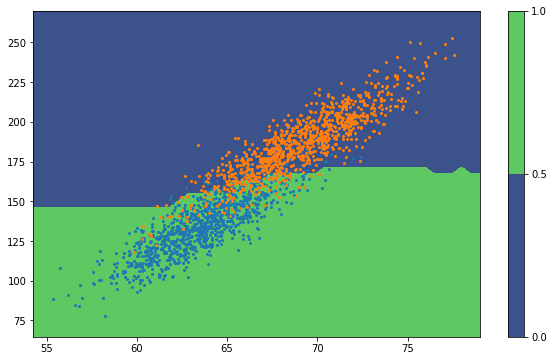

In [5]:
scores = []
ks = np.arange(1, 20)
for k in ks:
    M = KNeighborsClassifier(n_neighbors=k)
    score = np.mean(cross_val_score(M, X_tr, y_tr, cv=5, scoring="accuracy"))
    scores.append(score)

k_opt = ks[np.argmax(scores)]
print(f"k_opt = {k_opt}")

M = KNeighborsClassifier(n_neighbors=k_opt)
M.fit(X_tr, y_tr)
y_p = M.predict(X_te)
acc = np.sum(y_p == y_te)/len(y_te)
print(f"accuracy: {acc:.4}")

xmin = X.min(axis=0)
xmax = X.max(axis=0)
u = np.linspace(xmin[0], xmax[0], 50)
v = np.linspace(xmin[1], xmax[1], 50)

U, V = np.meshgrid(u, v)
UV = np.stack([U, V], axis=-1)
print(UV.shape)
W = np.zeros_like(U)

for j in range(50):
    W[:, j] = M.predict(UV[:, j, :])

plt.figure(figsize=(10, 6))    
c = plt.contourf(U, V, W, levels=[0, 0.5, 1])
plt.colorbar(c);
plt.plot(X_te[y_te == 1, 0], X_te[y_te == 1, 1], 'o', markersize=2)
plt.plot(X_te[y_te == 0, 0], X_te[y_te == 0, 1], 'o', markersize=2);

### Logistic Regression Classifier

accuracy: 0.9165
(50, 50, 2)


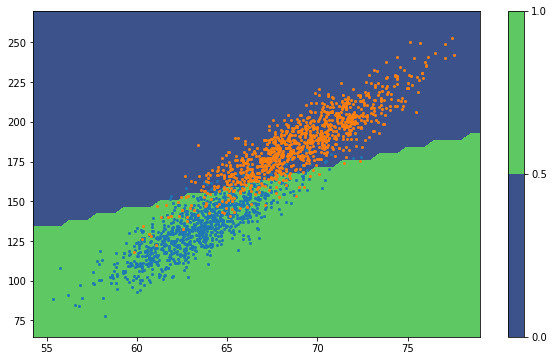

In [6]:
M = LogisticRegression(solver="lbfgs")
M.fit(X_tr, y_tr)
y_p = M.predict(X_te)
acc = np.sum(y_p == y_te)/len(y_te)
print(f"accuracy: {acc:.4}")

xmin = X.min(axis=0)
xmax = X.max(axis=0)
u = np.linspace(xmin[0], xmax[0], 50)
v = np.linspace(xmin[1], xmax[1], 50)

U, V = np.meshgrid(u, v)
UV = np.stack([U, V], axis=-1)
print(UV.shape)
W = np.zeros_like(U)

for j in range(50):
    W[:, j] = M.predict(UV[:, j, :])

plt.figure(figsize=(10, 6))    
c = plt.contourf(U, V, W, levels=[0, 0.5, 1])
plt.colorbar(c);
plt.plot(X_te[y_te == 1, 0], X_te[y_te == 1, 1], 'o', markersize=2)
plt.plot(X_te[y_te == 0, 0], X_te[y_te == 0, 1], 'o', markersize=2);

### Kernel Classifier

In [7]:
class KernelRegressor(BaseEstimator, ClassifierMixin):
    def __init__(self, K=None, h=None):
        if K is None:
            raise Exception("K cannot be None.")
        if h is None:
            raise Exception("h cannot be None.")        
        self.K = K
        self.h = h
        
    def fit(self, X, y):
        _X, _y = check_X_y(X, y)
        self._X = _X
        self._y = _y
    
    def predict_proba(self, X):
        X = check_array(X);
        dists = pairwise_distances(self._X, X)
        K_values = self.K(dists/self.h)
        return np.sum(K_values*self._y.reshape(-1, 1), axis=0)/np.sum(K_values, axis=0)
    
    def predict(self, X):
        return np.round(self.predict_proba(X))
    
def G(u):
    return np.exp(-np.square(u)/2)/np.sqrt(2*np.pi)

h_opt = 1.0
accuracy: 0.9185
(50, 50, 2)


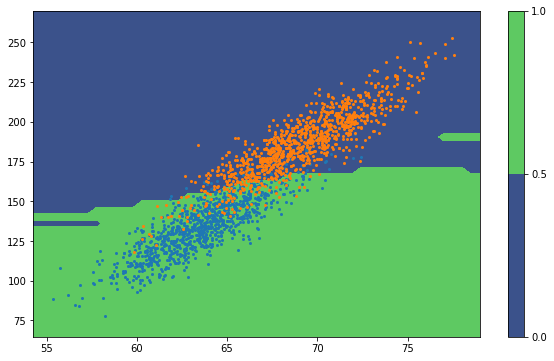

In [8]:
scores = []
hs = np.arange(0.5, 10, 0.5)
for h in hs:
    M = KernelRegressor(K=G, h=h)
    score = np.mean(cross_val_score(M, X_tr, y_tr, cv=5, scoring="accuracy"))
    scores.append(score)

h_opt = hs[np.argmax(scores)]
print(f"h_opt = {h_opt}")

M = KernelRegressor(K=G, h=h_opt)
M.fit(X_tr, y_tr)
y_p = M.predict(X_te)
acc = np.sum(np.round(y_p) == y_te)/len(y_te)
print(f"accuracy: {acc:.4}")

xmin = X.min(axis=0)
xmax = X.max(axis=0)
u = np.linspace(xmin[0], xmax[0], 50)
v = np.linspace(xmin[1], xmax[1], 50)

U, V = np.meshgrid(u, v)
UV = np.stack([U, V], axis=-1)
print(UV.shape)
W = np.zeros_like(U)

for j in range(50):
    W[:, j] = M.predict(UV[:, j, :])

plt.figure(figsize=(10, 6))    
c = plt.contourf(U, V, W, levels=[0, 0.5, 1])
plt.colorbar(c);
plt.plot(X_te[y_te == 1, 0], X_te[y_te == 1, 1], 'o', markersize=2)
plt.plot(X_te[y_te == 0, 0], X_te[y_te == 0, 1], 'o', markersize=2);